# Estudo e exploração dos dados para o Tech Challenge

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import numpy as np
from datetime import datetime
from cycler import cycler

In [2]:
#O arquivo tá com as colunas separadas por tabulação, separador é '\t'
vinhos_inicial = pd.read_csv('vinhoexp.csv', sep='\t', thousands='.', decimal=',')

vinhos_inicial.drop(columns=['Id'], inplace=True)

#o df tem duas colunas para cada ano, sendo elas 'quantidade (Kg)' e 'Valor (US$)'
#primeiro passo agora é: corrigir os nomes das colunas, alternando entre Quantidade e Valor (US$)

colunas_atuais = vinhos_inicial.columns[1:]  #ignorando a coluna dos países
novas_colunas = []

for i, col in enumerate(colunas_atuais):

    tipo = 'Quantidade' if i % 2 == 0 else 'Valor'

    novas_colunas.append(f'{tipo}_{col}')

vinhos_inicial.columns = ['País'] + novas_colunas


#separando colunas de quantidade e valor
quantidade_cols = [col for col in vinhos_inicial.columns if col.startswith('Quantidade')]
valor_cols = [col for col in vinhos_inicial.columns if col.startswith('Valor')]


#vou fazer a tabela ficar no formato "longo", com uma coluna para ano, quantidade e valor. Acredito que esse formato vai ser o ideal para trabalhar com os dados depois.
#Para isso, vou usar a função melt do pandas!!

df_qtd = vinhos_inicial.melt(id_vars='País', value_vars=quantidade_cols, var_name='Ano', value_name='Quantidade_L')
df_valor = vinhos_inicial.melt(id_vars='País', value_vars=valor_cols, var_name='Ano', value_name='Valor_USD')


#agora, é extrair o ano da coluna (limpar)

df_qtd['Ano'] = df_qtd['Ano'].str.extract(r'(\d+)', expand=False)
df_valor['Ano'] = df_valor['Ano'].str.extract(r'(\d+)', expand=False)


#por fim, tenho que juntar os dois dataframes e depois ajustar os tipos pra ficar certinho

vinhos = pd.merge(df_qtd, df_valor, on=['País', 'Ano']) #juntando com a base nas colunas ano e país :)

vinhos['Ano'] = vinhos['Ano'].astype(int)

vinhos['Quantidade_L'] = pd.to_numeric(vinhos['Quantidade_L'], errors='coerce').fillna(0) #o .fillna(0) substitui os valores inexistentes por zero, pra garantir que ta tudo bonitinho e certinho pra n dar problema no futuro

vinhos['Valor_USD'] = pd.to_numeric(vinhos['Valor_USD'], errors='coerce').fillna(0)


vinhos




,País,Ano,Quantidade_L,Valor_USD
0,Afeganistão,1970,0,0
1,África do Sul,1970,0,0
2,"Alemanha, República Democrática",1970,0,0
3,Angola,1970,0,0
4,Anguilla,1970,0,0
...,...,...,...,...
7750,Tuvalu,2024,0,0
7751,Uruguai,2024,36729,62325
7752,Vanuatu,2024,0,0
7753,Venezuela,2024,122922,199418


In [3]:
#Próximo passo: Filtrar os dados para 2010 até 2024!

vinhos = vinhos[(vinhos['Ano'] >= 2010) & (vinhos['Ano'] <= 2024)]

vinhos

,País,Ano,Quantidade_L,Valor_USD
5640,Afeganistão,2010,0,0
5641,África do Sul,2010,0,0
5642,"Alemanha, República Democrática",2010,27715,138666
5643,Angola,2010,33557,189891
5644,Anguilla,2010,0,0
...,...,...,...,...
7750,Tuvalu,2024,0,0
7751,Uruguai,2024,36729,62325
7752,Vanuatu,2024,0,0
7753,Venezuela,2024,122922,199418


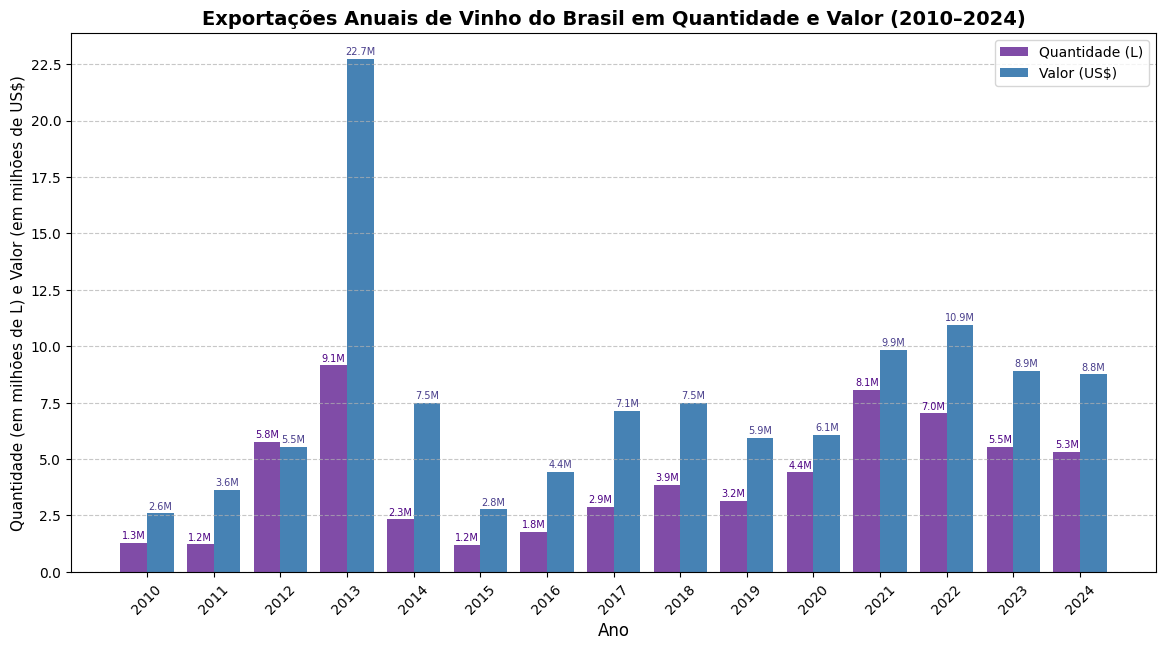

In [ ]:
#Agora, vou fazer um gráfico de barras com as exportações (em qtd e valor) por ano

#primeiro, soma a quantidade total e valor total por ano
vinhos_soma = vinhos.groupby('Ano')[['Quantidade_L', 'Valor_USD']].sum().reset_index()


largura = 0.4
anos = vinhos_soma['Ano']
x = np.arange(len(anos))

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(x - largura/2, vinhos_soma['Quantidade_L'], width=largura, label='Quantidade (L)', color='indigo', alpha = 0.7)
ax.bar(x + largura/2, vinhos_soma['Valor_USD'], width=largura, label='Valor (US$)', color='steelblue', alpha = 1) #gostei da paleta de cores, ficou bem equilibrado :)


ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Quantidade (em milhões de L) e Valor (em milhões de US$)', fontsize=11)
ax.set_title('Exportações Anuais de Vinho do Brasil em Quantidade e Valor (2010–2024)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(anos, rotation=45)
ax.legend(loc='upper right', frameon=True)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:,.1f}')) #dividindo os dados (não os do df) por 1 milhão pra melhorar a visualização	
ax.yaxis.set_major_locator(MultipleLocator(2.5e6))  #ticks a cada 2.5 milhões


#adicionando os valores acima das barras
for i in range(len(anos)):
    ax.text(x[i] - largura/2, vinhos_soma['Quantidade_L'][i] + 0.1e6, f'{vinhos_soma["Quantidade_L"][i]/1e6:.1f}M', ha='center', va='bottom', fontsize=7, color='indigo')
    
    ax.text(x[i] + largura/2, vinhos_soma['Valor_USD'][i] + 0.1e6, f'{vinhos_soma["Valor_USD"][i]/1e6:.1f}M', ha='center', va='bottom', fontsize=7, color='darkslateblue')


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


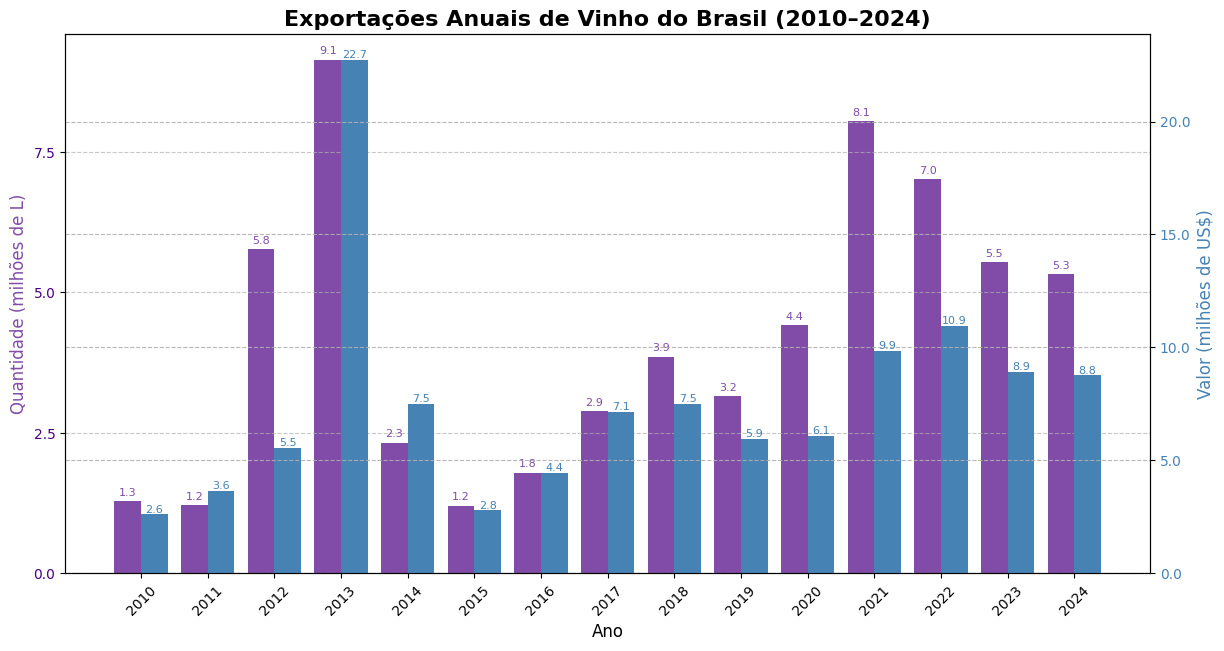

In [22]:
#agora fazendo um gráfico com dois eixos Y, para ver se ele fica mais claro do que o outro ou não

largura = 0.4
anos = vinhos_soma['Ano']
x = np.arange(len(anos))

fig, ax1 = plt.subplots(figsize=(14, 7))

#primeiro eixo (esquerda) - Quantidade
barras1 = ax1.bar(x - largura/2, vinhos_soma['Quantidade_L'], width=largura, color='indigo', alpha = 0.7, label='Quantidade (L)')
ax1.set_ylabel('Quantidade (milhões de L)', fontsize=12, color='indigo', alpha = 0.7)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(2.5e6))
ax1.tick_params(axis='y', labelcolor='indigo')

#segundo eixo (direita) - Valor
ax2 = ax1.twinx()
barras2 = ax2.bar(x + largura/2, vinhos_soma['Valor_USD'], width=largura, color='steelblue', label='Valor (US$)')
ax2.set_ylabel('Valor (milhões de US$)', fontsize=12, color='steelblue')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}'))
ax2.tick_params(axis='y', labelcolor='steelblue')

#rótulos, título e etc
ax1.set_xlabel('Ano', fontsize=12)
ax1.set_title('Exportações Anuais de Vinho do Brasil (2010–2024)', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(anos, rotation=45)

#adicionar valores sobre as barras
for i in range(len(anos)):
    ax1.text(x[i] - largura/2, vinhos_soma['Quantidade_L'][i] + 0.1e6, f'{vinhos_soma["Quantidade_L"][i]/1e6:.1f}', ha='center', fontsize=8, color='indigo', alpha = 0.7)
    ax2.text(x[i] + largura/2, vinhos_soma['Valor_USD'][i] + 0.1e6, f'{vinhos_soma["Valor_USD"][i]/1e6:.1f}', ha='center', fontsize=8, color='steelblue')

#grids nos dois eixos? continua esquisito 
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax2.grid(axis='y', linestyle='--', alpha=0.9)

plt.show()

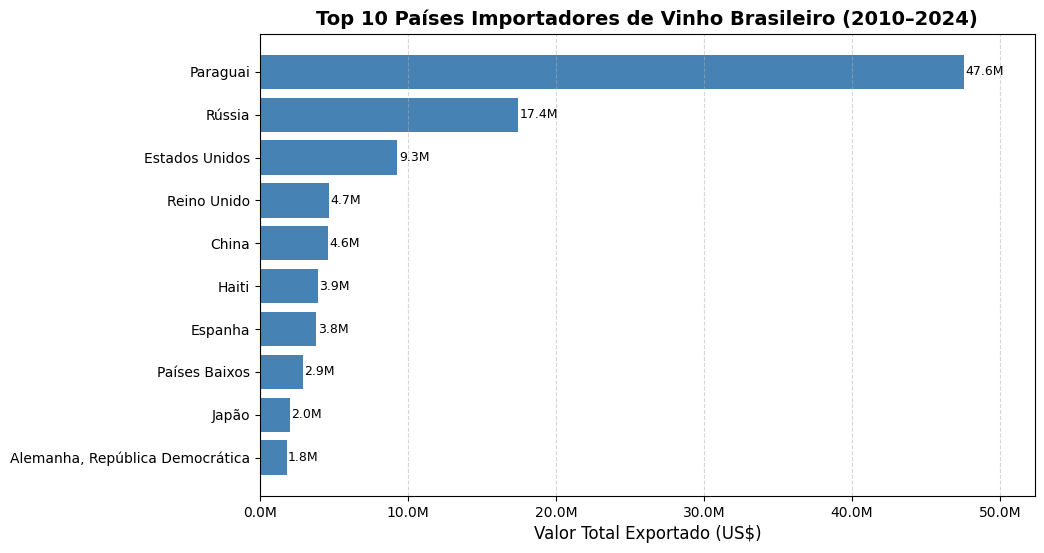

In [16]:
#conclusão: acho que ficou uma bosta o gráfico com dois eixos. Ficou super confuso, apesar de mais verticalmente equilibrado. DESCARTADO!
#próxima tentativa: gráfico por país (top 5 ou top 10?)
#escolher qual abordagem usar: ranking total acumulado; ano mais recente; evolução ano a ano por país etc. (talvez todas?)

#começando por ranking total acumulado:

ranking_paises = vinhos.groupby('País')['Valor_USD'].sum().sort_values(ascending=False).head(10)  #agrupa e soma valor total por país

#Vou fazer um gráfico de barras horizontais, acho que é o que mais combina com um ranking
fig, ax = plt.subplots(figsize=(10, 6))
ranking_paises = ranking_paises.sort_values()  # ordena de baixo para cima no gráfico
bars = ax.barh(ranking_paises.index, ranking_paises.values, color='steelblue')

#adicionando rótulos nas barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + 1e5, bar.get_y() + bar.get_height()/2, f'{width/1e6:.1f}M', va='center', fontsize=9)

ax.set_xlabel('Valor Total Exportado (US$)', fontsize=12)
ax.set_title('Top 10 Países Importadores de Vinho Brasileiro (2010–2024)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.set_xlim(0, ranking_paises.max() * 1.1)  # adiciona um pouco de espaço à direita do gráfico

plt.show()


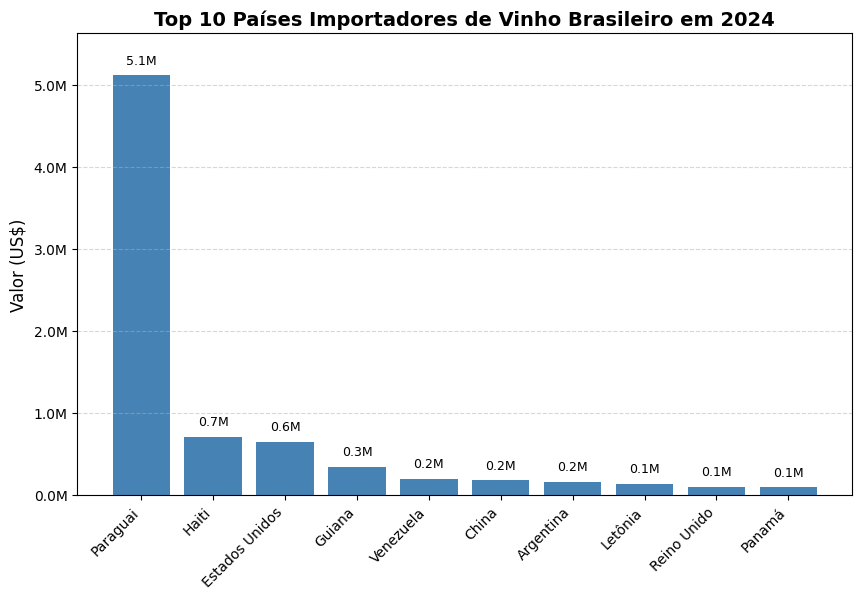

In [38]:
#Limitação: não mostra se estão crescendo ou caindo
#bom para mostrar os "campeões" de longo prazo

#próximo gráfico é: os top países em 2024 (podendo escolher o ano que quiser hehe)

ano_escolhido = 2024
vinhos_ano = vinhos[vinhos['Ano'] == ano_escolhido]
ranking_ano = vinhos_ano.groupby('País')['Valor_USD'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ranking_ano.index, ranking_ano.values, color='steelblue')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1e5, f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Valor (US$)', fontsize=12)
ax.set_title(f'Top 10 Países Importadores de Vinho Brasileiro em {ano_escolhido}', fontsize=14, fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

ax.set_xticks(range(len(ranking_ano)))
ax.set_xticklabels(ranking_ano.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylim(0, ranking_ano.max() * 1.1) #pra ajustar o limite do eixo y, deixando um espaço em cima das barras, de acordo com o valor máximo

plt.show()


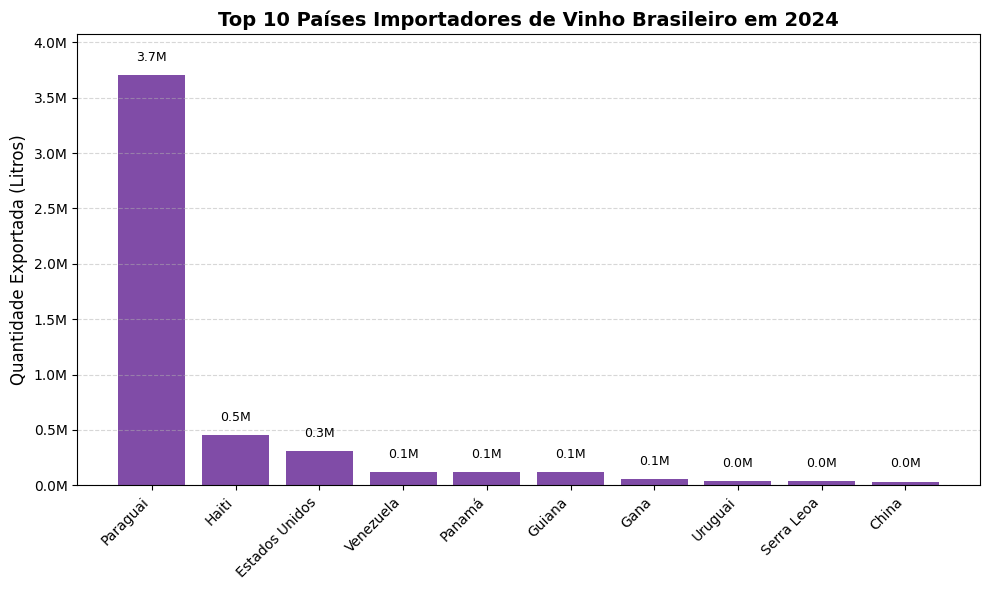

In [39]:
#quero fazer também um igual a esse só que com a quantidade em litros também 
#pode não ser muito relevante, mas acho que é válido ter ele :)


ranking_ano = vinhos_ano.groupby('País')['Quantidade_L'].sum().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ranking_ano.index, ranking_ano.values, color='indigo', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1e5, f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=9)

ax.set_ylabel(f'Quantidade Exportada (Litros)', fontsize=12)
ax.set_title(f'Top 10 Países Importadores de Vinho Brasileiro em {ano_escolhido}', fontsize=14, fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

ax.set_xticks(range(len(ranking_ano)))
ax.set_xticklabels(ranking_ano.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylim(0, ranking_ano.max() * 1.1)

plt.tight_layout()
plt.show()

In [32]:
#o foda nesses dois gráficos é que o paraguai, por exemplo, tem um valor muuuuuuuito mais alto entao as outras 
#barras quando vai chegando no final do ranking ficam minúsculas e não da pra ver nem fazer nenhuma comparação entre elas..

#o que dá pra fazer, caso a gente siga com esses gráficos no relatório final, é talvez excluir os primeiros 3 países ou algo assim do ranking
#pq ai fica visível o que que rola com o restante dos países!!

#uma análise legal que dá pra fazer é comparar esse gráfico com o gráfico de valor, que aí mostra quem ta importando 
#vinho mais barato ou caro//quem tá pagando mais caro ou barato por litro
#falando nisso, vou fazer um gráfico valor por litro entre os países agora :)


#Seguindo adiante então:

#primeiro passo é fazer uma nova coluna no df com o preço por litro:
#LEMBRANDO que pode ter a quantidade 0 frequentemente, então tem que se preparar pra esses casos:


#vinhos['Preco_Litro'] = vinhos.apply(lambda row: row['Valor_USD'] / row['Quantidade_L'] if row['Quantidade_L'] > 0 else 0, axis=1)


#explicação do que que é esse lambda e como funciona isso aqui:

#lambda é uma forma abreviada de criar uma função simples e rápida. É o mesmo que def, só que inline (sem nome) -> em def seria def nome_funcao(etc)
#aqui, row é uma linha do dataframe, passada linha por linha pela função apply() do pandas
#vinhos.apply(lambda row: row['Valor_USD'] / row['Quantidade_L'], axis=1) significa: 
# “Para cada linha (row) do dataframe pegue o Valor_USD e divida pelo Quantidade_L e retorne esse valor como o preço por litro.”


vinhos.loc[:, 'Preco_Litro'] = vinhos.apply(lambda row: row['Valor_USD'] / row['Quantidade_L'] if row['Quantidade_L'] > 0 else 0, axis=1)

#tive que usar o .loc tal para mostrar pro pandas que eu tava querendo editar a coluna toda do dataframe original, e não só uma cópia dela 
# (porque antes eu fiz vinhos = vinhos[(vinhos['Ano'] >= 2010) & (vinhos['Ano'] <= 2024)], lá em cima!) aí ele me mostra um warning pra confirmar isso. Agora tá certinho!

vinhos


,País,Ano,Quantidade_L,Valor_USD,Preco_Litro
5640,Afeganistão,2010,0,0,0.000000
5641,África do Sul,2010,0,0,0.000000
5642,"Alemanha, República Democrática",2010,27715,138666,5.003283
5643,Angola,2010,33557,189891,5.658760
5644,Anguilla,2010,0,0,0.000000
...,...,...,...,...,...
7750,Tuvalu,2024,0,0,0.000000
7751,Uruguai,2024,36729,62325,1.696888
7752,Vanuatu,2024,0,0,0.000000
7753,Venezuela,2024,122922,199418,1.622313


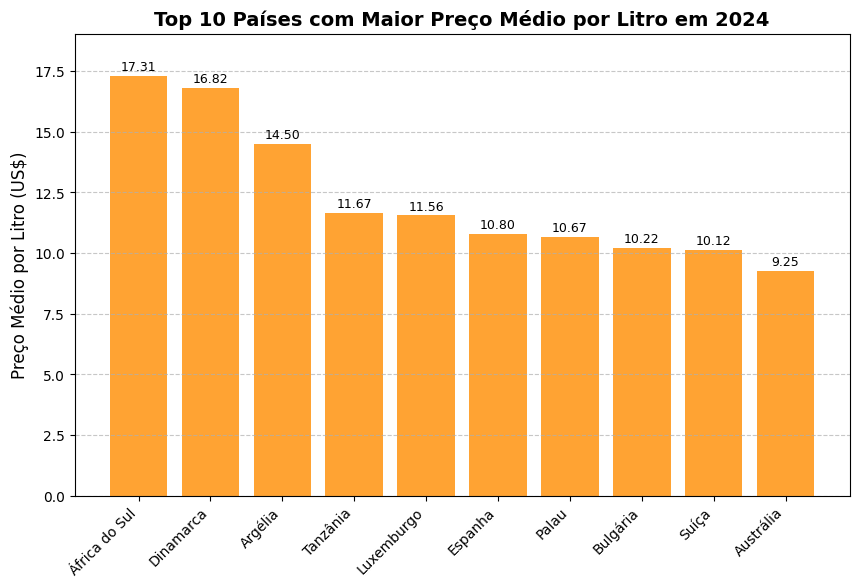

In [41]:
#Agora sim, fazendo o gráfico!

vinhos_ano = vinhos[vinhos['Ano'] == ano_escolhido] #tive que definir dnv pq eu mudei o df né então ele ainda n tava atualizado com a coluna nova
ranking_preco = vinhos_ano.groupby('País')['Preco_Litro'].mean().sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ranking_preco.index, ranking_preco.values, color='darkorange', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Preço Médio por Litro (US$)', fontsize=12)
ax.set_title(f'Top 10 Países com Maior Preço Médio por Litro em {ano_escolhido}', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(ranking_preco)))
ax.set_xticklabels(ranking_preco.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, ranking_preco.max() * 1.1)

plt.show()

In [ ]:
#esse gráfico é bom pra:
#mostrar onde estão os mercados de maior valor agregado
#discutir estratégias de exportação premium
#propor ações de segmentação geográfica e de produto
#etc e tal

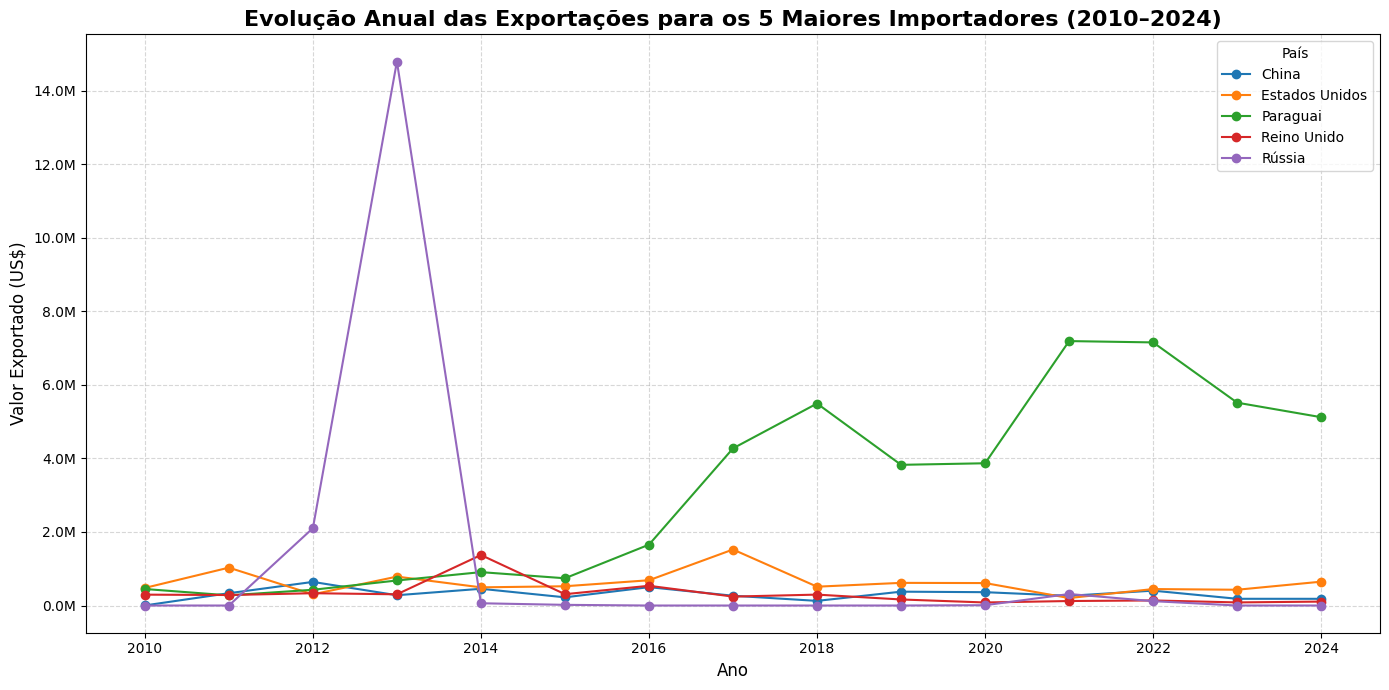

In [ ]:
#agora vamos para o gráfico de evolução ano a ano por país (considerando apenas os top 5 países totais no período)

top5_paises = vinhos.groupby('País')['Valor_USD'].sum().sort_values(ascending=False).head(5).index
vinhos_top5 = vinhos[vinhos['País'].isin(top5_paises)]
evolucao_top5 = vinhos_top5.groupby(['Ano', 'País'])['Valor_USD'].sum().unstack()

fig, ax = plt.subplots(figsize=(14, 7))
evolucao_top5.plot(ax=ax, marker='o')

ax.set_title('Evolução Anual das Exportações para os 5 Maiores Importadores (2010–2024)', fontsize=16, fontweight='bold')
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Valor Exportado (US$)', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.grid(axis='both', linestyle='--', alpha=0.5)
ax.legend(title='País')

plt.show()

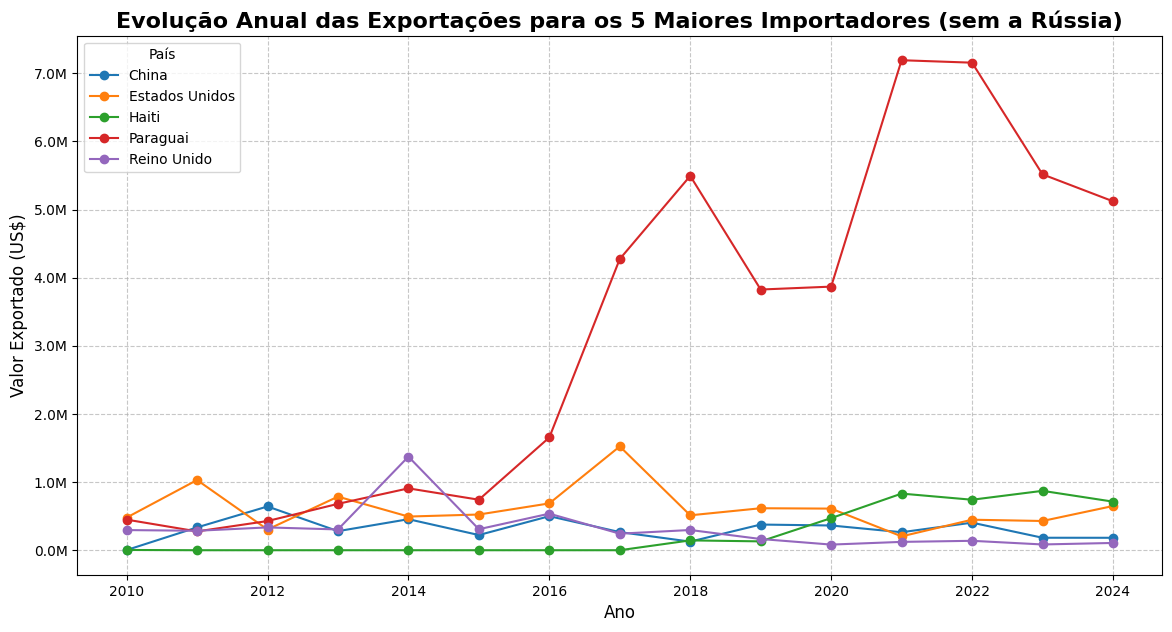

In [44]:
#esse pico escroto da russia ta atrapalhando a visualização, podemos fazer um gráfico excluindo ela e pegando o proximo pais no top 5

ranking_geral = vinhos.groupby('País')['Valor_USD'].sum().sort_values(ascending=False)
top5_sem_russia = ranking_geral[ranking_geral.index != 'Rússia'].head(5).index

vinhos_top5_alt = vinhos[vinhos['País'].isin(top5_sem_russia)]

evolucao_top5_alt = vinhos_top5_alt.groupby(['Ano', 'País'])['Valor_USD'].sum().unstack()

fig, ax = plt.subplots(figsize=(14, 7))
evolucao_top5_alt.plot(ax=ax, marker='o')

ax.set_title('Evolução Anual das Exportações para os 5 Maiores Importadores (sem a Rússia)', fontsize=16, fontweight='bold')
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('Valor Exportado (US$)', fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax.grid(axis='both', linestyle='--', alpha=0.7)
ax.legend(title='País')

plt.show()



In [ ]:
#o bom desse gráfico é que ele mostra tendência por país, não só quem comprou mais (olhando diretamente para a rússia 👀)
#paraguai tá fortíssimo nos ultimos anos!

#outra coisa que dá pra fazer é pegar o top países que importaram num período específico (tipo 2010 até 2015 por exemplo) e refazer esse gráfico. 
#pode ser que tenha algum(ns) países que importavam muito antes e diminuíram recentemente. 
#por ex o Haiti, que importava pouquissimo antes de 2018 e começou a importar tanto que virou o top 6..


In [ ]:
#acho que agora chega de fazer gráficos desse df especificamente por enquanto. Vou tratar os dados climáticos agora e depois vamos ver o que dá pra fazer de correlações e análises :)


Parte Climática

In [79]:
#Depois de muita luta, escolhi quais vao ser as estações ideais para usar (documentado no docs)! São elas: 
#Bento Gonçalves (A840) (principal!), Santana do Livramento (A804) e Vacaria (A880)

#ler os dados:

bento = pd.read_csv('BentoGoncalves.csv', sep=";", skiprows=10, encoding="latin1", decimal=",")
#livramento = pd.read_csv('SantanaDoLivramento.csv', sep=";", skiprows=10, encoding="latin1", decimal=",")
bage = pd.read_csv('Bage.csv', sep=";", skiprows=10, encoding="latin1", decimal=",")
vacaria = pd.read_csv('Vacaria.csv', sep=";", skiprows=10, encoding="latin1", decimal=",")



#adicionando coluna com nome da estação
bento["Estacao"] = "Bento Gonçalves"
#livramento["Estacao"] = "Santana do Livramento"
bage["Estacao"] = "Bage"
vacaria["Estacao"] = "Vacaria"

#juntando em um único dataframe
clima = pd.concat([bento, bage, vacaria], ignore_index=True)

clima
#tem vários buracos nos dados......... :/ 
#Tenho a opção de tentar procurar outras estações pra verse elas tão completas, mas no momento tô com preguiça 
#acho que vou ver se preencho os buracos com as médias por enquanto pra ver se fica OK, mas isso pode enviesar os dados... tanto pra baixo quanto pra cima

#pesando os prós e contras das rotas:
### Faltam poucos meses -- (≤ 15–20 % do total entre 2010-2024, sem grandes “buracos” consecutivos na vindima — jan-mar) -> vindima é a colheita das uvas (período mais relevante pra nós talvez)
### se sim, manter as estações e imputar os dados

### Faltam muitos meses ou há lacunas longas em 2 + anos críticos (tem que ver quais seriam esses)
### se sim, é melhor trocar a estação com maior falta (por ex usar a estação Canela se Bento tivesse buracos demais) E imputar lacunas pequenas nas demais

#então tenho que verificar a % de dados faltantes por estação.. Vamos lá!


,Data Medicao,"NUMERO DE DIAS COM PRECIP. PLUV, MENSAL (AUT)(nÃºmero)","PRECIPITACAO TOTAL, MENSAL (AUT)(mm)","PRESSAO ATMOSFERICA, MEDIA MENSAL (AUT)(mB)","TEMPERATURA MEDIA, MENSAL (AUT)(Â°C)","VENTO, VELOCIDADE MAXIMA MENSAL (AUT)(m/s)","VENTO, VELOCIDADE MEDIA MENSAL (AUT)(m/s)",Unnamed: 7,Estacao
0,2010-01-31,18.0,278.4,941.5,21.9,7.0,2.5,NaN,Bento Gonçalves
1,2010-02-28,14.0,161.4,942.1,23.0,9.7,2.8,NaN,Bento Gonçalves
2,2010-03-31,19.0,58.4,942.6,20.7,7.0,2.2,NaN,Bento Gonçalves
3,2010-04-30,14.0,136.4,946.2,17.6,8.5,2.4,NaN,Bento Gonçalves
4,2010-05-31,21.0,158.6,946.0,14.3,6.8,2.2,NaN,Bento Gonçalves
...,...,...,...,...,...,...,...,...,...
535,2024-08-31,12.0,88.2,909.0,12.8,10.3,3.7,NaN,Vacaria
536,2024-09-30,12.0,128.0,906.6,16.2,13.5,4.1,NaN,Vacaria
537,2024-10-31,13.0,195.0,906.1,16.5,11.2,3.9,NaN,Vacaria
538,2024-11-30,11.0,96.6,904.9,18.3,9.0,3.9,NaN,Vacaria


In [94]:
#Para que a função falta_pct seja útil, preciso selecionar quais colunas vão ser usadas nas análises. Então, vamos remover as que não são tão relevantes!
#Vou manter: frequência de chuva(num. de dias c precip.), precipitação total e temperatura média! A coluna estação e data vão ficar também.

cols_manter = {
    'Data Medicao' : 'Data',   
    'NUMERO DE DIAS COM PRECIP. PLUV, MENSAL (AUT)(nÃºmero)': 'DiasChuva',
    'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)': 'PrecipTotal',
    'TEMPERATURA MEDIA, MENSAL (AUT)(Â°C)': 'TempMedia',
    'Estacao': 'Estacao'          
}

#aproveitar e já renomear elas tbm

clima_sel = clima[list(cols_manter.keys())].rename(columns=cols_manter)

#converte a data para datetime e define como índice
clima_sel['Data'] = pd.to_datetime(clima_sel['Data'])  
clima_sel = clima_sel.set_index('Data')

clima_sel


#OK!


,DiasChuva,PrecipTotal,TempMedia,Estacao
Data,,,,
2010-01-31,18.0,278.4,21.9,Bento Gonçalves
2010-02-28,14.0,161.4,23.0,Bento Gonçalves
2010-03-31,19.0,58.4,20.7,Bento Gonçalves
2010-04-30,14.0,136.4,17.6,Bento Gonçalves
2010-05-31,21.0,158.6,14.3,Bento Gonçalves
...,...,...,...,...
2024-08-31,12.0,88.2,12.8,Vacaria
2024-09-30,12.0,128.0,16.2,Vacaria
2024-10-31,13.0,195.0,16.5,Vacaria


In [ ]:
#criando um índice mensal completo

idx_full = pd.date_range('2010-01-01', '2024-12-31', freq='ME')


#definindo quais colunas climáticas contam
clima_cols = ['TempMedia', 'PrecipTotal', 'DiasChuva']   #pra evitar que a coluna estacao entre na contagem de NaNs e atrapalhe


#função pra contar os NaNs e calcular a porcentagem de dados faltantes
def falta_pct(df_est):
    df_alinh = df_est.reindex(idx_full)

    sub = df_alinh[clima_cols]          # só variáveis de interesse

    any_nan  = sub.isna().any(axis=1).sum()
    all_nan  = sub.isna().all(axis=1).sum()
    total    = len(idx_full)

    return pd.Series({
        '%≥1 NaN':   any_nan  / total * 100,
        '%Todos NaN': all_nan / total * 100
    })


faltas = (clima_sel.groupby('Estacao').apply(falta_pct, include_groups=False))
print(faltas)


                  %≥1 NaN  %Todos NaN
Estacao                              
Bage             7.777778    1.666667
Bento Gonçalves  7.222222    1.111111
Vacaria          8.333333    3.333333


In [ ]:
#Com esse resultado, temos que bento e vacaria estão aceitáveis, mas livramento tem muitos dados faltando. Então, vou trocar ela por Bagé.
#Como eu só substitui a estação lá em cima no código, pra quem tá vendo pela primeira vez vai parecer como se eu nunca nem tivesse usado Santana do Livramento hehe
#mas eu usei e ela tava uma merda!